In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [ ]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3,
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Рассчитаем аналитически</h3>
    <b>Веса в self.input_layer</b>
    <div>input_size * hidden_size + hidden_size = 6 * 3 + 6</div>
    <b>Веса в каждом из слоев в self.hidden_layers</b>
    <div>(hidden_size * hidden_size + hidden_size) * n_hidden = (6 * 6 + 6) * 1</div>
    <b>Веса в self.output_layer</b>
    <div>hidden_size * output_size + output_size = 6 * 7 + 7</div>
    <br>
    <b>Итого</b>
    <div>6 * 3 + 6 + (6 * 6 + 6) * 1 + 6 * 7 + 7 = 115</div>
</div>

In [ ]:
model = DeepMLP(3, 6, 7, 1)

model_parameters = filter(lambda param: param.requires_grad, model.parameters())
answer = sum([np.prod(param.size()) for param in model_parameters])

answer   ### здесь должен быть выведен ответ

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [ ]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>1. Посчитаем mean по градиентам весов hidden_layers[0].weight.grad</div>
    <div>2. Посчитаем mean по градиентам смещений hidden_layers[0].bias.grad</div>
</div>

In [ ]:
first_hidden_layer_grads = model.hidden_layers[0].weight.grad  # Градиенты весов первого скрытого слоя
first_hidden_layer_bias_grads = model.hidden_layers[0].bias.grad  # Градиенты смещений первого скрытого слоя

mean_grad_weight = torch.mean(first_hidden_layer_grads)
mean_grad_bias = torch.mean(first_hidden_layer_bias_grads)

print("Среднее значение по градиенту весов первого скрытого слоя:", mean_grad_weight.item())
print("Среднее значение по градиенту смещений первого скрытого слоя:", mean_grad_bias.item())

Среднее значение по градиенту весов первого скрытого слоя: 0.001038502436131239
Среднее значение по градиенту смещений первого скрытого слоя: -0.009553598240017891


In [ ]:
# Выведем, например, веса
answer = mean_grad_weight.item()
answer ### здесь должен быть выведен ответ

0.001038502436131239

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [ ]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Вызываем forward с полученным тензоров test_data и суммируем значения полученного массива</div>
</div>

In [ ]:
test_data = torch.rand((1, 28*28)).to(device)
output = model(test_data)

answer = torch.sum(output)
answer   ### здесь должен быть выведен ответ

tensor(-0.5516, device='cuda:0', grad_fn=<SumBackward0>)

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [ ]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16659685.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494714.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4596385.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9530029.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')

      fc_gradients.append(torch.mean(model.hidden_layers[0].weight.grad))  # <------ код из решения задачи 2

  return fc_gradients

In [ ]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  1%|          | 8/938 [00:00<01:24, 11.04it/s]

Step: 0, Loss: 2.2937896251678467


  1%|▏         | 13/938 [00:01<01:01, 14.97it/s]

Step: 10, Loss: 2.2889366149902344


  2%|▏         | 23/938 [00:01<00:49, 18.35it/s]

Step: 20, Loss: 2.291050672531128


  4%|▍         | 39/938 [00:02<00:27, 32.38it/s]

Step: 30, Loss: 2.154609441757202


  5%|▌         | 49/938 [00:02<00:24, 36.72it/s]

Step: 40, Loss: 2.016479015350342
Step: 50, Loss: 1.8274005651474


  7%|▋         | 65/938 [00:02<00:21, 41.02it/s]

Step: 60, Loss: 1.6792889833450317


  8%|▊         | 76/938 [00:02<00:20, 42.62it/s]

Step: 70, Loss: 1.569961667060852


  9%|▉         | 86/938 [00:03<00:21, 40.05it/s]

Step: 80, Loss: 1.4565768241882324


 10%|█         | 96/938 [00:03<00:20, 41.49it/s]

Step: 90, Loss: 1.5084950923919678


 11%|█▏        | 106/938 [00:03<00:20, 40.31it/s]

Step: 100, Loss: 1.364181399345398


 13%|█▎        | 118/938 [00:03<00:16, 48.80it/s]

Step: 110, Loss: 1.395524501800537
Step: 120, Loss: 1.2927829027175903


 15%|█▍        | 137/938 [00:04<00:23, 34.44it/s]

Step: 130, Loss: 1.172381043434143


 15%|█▌        | 145/938 [00:04<00:26, 29.85it/s]

Step: 140, Loss: 1.2509260177612305


 16%|█▋        | 153/938 [00:05<00:28, 27.29it/s]

Step: 150, Loss: 1.1494622230529785


 17%|█▋        | 164/938 [00:05<00:29, 26.57it/s]

Step: 160, Loss: 1.1668161153793335


 19%|█▊        | 174/938 [00:05<00:29, 25.58it/s]

Step: 170, Loss: 1.220613956451416


 20%|█▉        | 183/938 [00:06<00:31, 23.62it/s]

Step: 180, Loss: 1.3069820404052734


 21%|██        | 195/938 [00:06<00:35, 20.92it/s]

Step: 190, Loss: 0.946485161781311


 22%|██▏       | 205/938 [00:07<00:34, 21.32it/s]

Step: 200, Loss: 0.8249154686927795


 23%|██▎       | 217/938 [00:07<00:25, 28.67it/s]

Step: 210, Loss: 1.3002018928527832


 24%|██▍       | 224/938 [00:08<00:27, 26.07it/s]

Step: 220, Loss: 1.1068321466445923


 25%|██▌       | 238/938 [00:08<00:21, 33.01it/s]

Step: 230, Loss: 1.0789337158203125


 26%|██▋       | 247/938 [00:08<00:19, 35.76it/s]

Step: 240, Loss: 1.1287155151367188


 27%|██▋       | 255/938 [00:08<00:20, 33.11it/s]

Step: 250, Loss: 1.045046091079712


 28%|██▊       | 264/938 [00:09<00:18, 35.99it/s]

Step: 260, Loss: 1.0151885747909546


 29%|██▉       | 276/938 [00:09<00:19, 34.78it/s]

Step: 270, Loss: 0.8476772308349609


 30%|███       | 285/938 [00:09<00:17, 37.14it/s]

Step: 280, Loss: 0.9521381258964539


 32%|███▏      | 296/938 [00:10<00:15, 40.27it/s]

Step: 290, Loss: 0.7699106335639954


 33%|███▎      | 307/938 [00:10<00:14, 44.85it/s]

Step: 300, Loss: 1.1782273054122925
Step: 310, Loss: 0.8225458860397339


 35%|███▍      | 327/938 [00:10<00:10, 57.20it/s]

Step: 320, Loss: 1.0159187316894531
Step: 330, Loss: 0.8963613510131836


 37%|███▋      | 351/938 [00:10<00:08, 66.15it/s]

Step: 340, Loss: 0.894009530544281
Step: 350, Loss: 0.8441407680511475


 40%|███▉      | 373/938 [00:11<00:08, 64.28it/s]

Step: 360, Loss: 0.8699902296066284
Step: 370, Loss: 0.9404324293136597


 41%|████      | 386/938 [00:11<00:10, 53.29it/s]

Step: 380, Loss: 0.8298032283782959


 42%|████▏     | 398/938 [00:11<00:11, 46.39it/s]

Step: 390, Loss: 0.8056067228317261


 44%|████▎     | 409/938 [00:12<00:10, 48.61it/s]

Step: 400, Loss: 0.9474304914474487
Step: 410, Loss: 0.8397301435470581


 46%|████▌     | 432/938 [00:12<00:08, 61.07it/s]

Step: 420, Loss: 0.7543426752090454
Step: 430, Loss: 0.7021985650062561


 48%|████▊     | 447/938 [00:12<00:07, 64.76it/s]

Step: 440, Loss: 0.6798675656318665
Step: 450, Loss: 0.6756791472434998


 50%|█████     | 471/938 [00:12<00:06, 69.69it/s]

Step: 460, Loss: 0.9879452586174011
Step: 470, Loss: 0.530322253704071


 52%|█████▏    | 487/938 [00:13<00:06, 69.47it/s]

Step: 480, Loss: 0.5808587074279785
Step: 490, Loss: 0.695310652256012


 54%|█████▍    | 509/938 [00:13<00:06, 66.43it/s]

Step: 500, Loss: 0.8470647931098938
Step: 510, Loss: 0.8692700862884521


 57%|█████▋    | 531/938 [00:13<00:06, 66.49it/s]

Step: 520, Loss: 0.9202135801315308
Step: 530, Loss: 0.9786092042922974


 58%|█████▊    | 548/938 [00:14<00:05, 68.69it/s]

Step: 540, Loss: 0.7890682816505432
Step: 550, Loss: 0.842555582523346


 61%|██████    | 572/938 [00:14<00:05, 72.19it/s]

Step: 560, Loss: 0.8212042450904846
Step: 570, Loss: 1.0312821865081787


 63%|██████▎   | 588/938 [00:14<00:05, 68.67it/s]

Step: 580, Loss: 0.897013783454895
Step: 590, Loss: 0.9745898246765137


 65%|██████▌   | 610/938 [00:14<00:04, 70.31it/s]

Step: 600, Loss: 0.614892303943634
Step: 610, Loss: 0.8571321964263916


 68%|██████▊   | 634/938 [00:15<00:04, 69.63it/s]

Step: 620, Loss: 0.5909349322319031
Step: 630, Loss: 0.9711124897003174


 69%|██████▉   | 649/938 [00:15<00:04, 68.42it/s]

Step: 640, Loss: 0.6752397418022156
Step: 650, Loss: 0.793038547039032


 72%|███████▏  | 673/938 [00:15<00:03, 71.86it/s]

Step: 660, Loss: 0.8021664619445801
Step: 670, Loss: 0.6898663640022278


 73%|███████▎  | 689/938 [00:16<00:03, 69.28it/s]

Step: 680, Loss: 0.9239345788955688
Step: 690, Loss: 0.8560190200805664


 76%|███████▌  | 713/938 [00:16<00:03, 70.79it/s]

Step: 700, Loss: 0.6427173614501953
Step: 710, Loss: 0.7232307195663452


 78%|███████▊  | 729/938 [00:16<00:03, 68.85it/s]

Step: 720, Loss: 0.8339681625366211
Step: 730, Loss: 0.6960524320602417


 80%|████████  | 752/938 [00:16<00:02, 72.53it/s]

Step: 740, Loss: 0.6204549670219421
Step: 750, Loss: 0.3275142014026642


 83%|████████▎ | 776/938 [00:17<00:02, 71.65it/s]

Step: 760, Loss: 0.655512809753418
Step: 770, Loss: 0.6526492238044739


 84%|████████▍ | 792/938 [00:17<00:02, 70.99it/s]

Step: 780, Loss: 0.5388124585151672
Step: 790, Loss: 0.7175283432006836


 86%|████████▌ | 807/938 [00:17<00:02, 55.62it/s]

Step: 800, Loss: 0.47889837622642517


 87%|████████▋ | 819/938 [00:18<00:02, 50.38it/s]

Step: 810, Loss: 0.5588071346282959


 88%|████████▊ | 825/938 [00:18<00:02, 49.15it/s]

Step: 820, Loss: 0.600587785243988


 89%|████████▉ | 837/938 [00:18<00:02, 49.04it/s]

Step: 830, Loss: 0.6281799077987671


 90%|█████████ | 847/938 [00:18<00:01, 46.10it/s]

Step: 840, Loss: 0.4902746379375458


 92%|█████████▏| 859/938 [00:19<00:01, 47.02it/s]

Step: 850, Loss: 1.0378198623657227


 93%|█████████▎| 870/938 [00:19<00:01, 46.50it/s]

Step: 860, Loss: 0.645628035068512


 93%|█████████▎| 875/938 [00:19<00:01, 45.24it/s]

Step: 870, Loss: 0.6482465863227844


 94%|█████████▍| 885/938 [00:19<00:01, 43.69it/s]

Step: 880, Loss: 0.556383490562439


 96%|█████████▌| 896/938 [00:19<00:01, 41.54it/s]

Step: 890, Loss: 0.619185209274292


 97%|█████████▋| 908/938 [00:20<00:00, 43.23it/s]

Step: 900, Loss: 0.7866921424865723


 98%|█████████▊| 918/938 [00:20<00:00, 40.75it/s]

Step: 910, Loss: 0.4500378370285034


 99%|█████████▉| 928/938 [00:20<00:00, 40.50it/s]

Step: 920, Loss: 0.6020404696464539


 99%|█████████▉| 933/938 [00:20<00:00, 41.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 938/938 [00:20<00:00, 44.94it/s]

Step: 930, Loss: 0.5132187008857727


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [ ]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Посчитаем размер model.hidden_layers</div>
</div>

In [ ]:
answer = len(model.hidden_layers)
answer   ### здесь должен быть выведен ответ

10

In [ ]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 11/938 [00:00<00:16, 55.71it/s]

Step: 0, Loss: 2.3116233348846436
Step: 10, Loss: 2.2927772998809814


  3%|▎         | 31/938 [00:00<00:15, 59.55it/s]

Step: 20, Loss: 2.328972816467285
Step: 30, Loss: 2.3101611137390137


  6%|▌         | 52/938 [00:00<00:14, 61.75it/s]

Step: 40, Loss: 2.3166162967681885
Step: 50, Loss: 2.334524154663086


  8%|▊         | 73/938 [00:01<00:13, 62.08it/s]

Step: 60, Loss: 2.3023855686187744
Step: 70, Loss: 2.3015942573547363


  9%|▉         | 87/938 [00:01<00:13, 63.46it/s]

Step: 80, Loss: 2.3111729621887207
Step: 90, Loss: 2.2827999591827393


 12%|█▏        | 109/938 [00:01<00:14, 59.05it/s]

Step: 100, Loss: 2.3095767498016357
Step: 110, Loss: 2.2963790893554688


 14%|█▍        | 131/938 [00:02<00:12, 63.44it/s]

Step: 120, Loss: 2.2688260078430176
Step: 130, Loss: 2.2773725986480713


 16%|█▌        | 152/938 [00:02<00:12, 62.82it/s]

Step: 140, Loss: 2.292206048965454
Step: 150, Loss: 2.307490348815918


 18%|█▊        | 167/938 [00:02<00:12, 62.77it/s]

Step: 160, Loss: 2.305772542953491
Step: 170, Loss: 2.2927846908569336


 20%|██        | 188/938 [00:03<00:12, 61.02it/s]

Step: 180, Loss: 2.2967801094055176
Step: 190, Loss: 2.303372383117676


 22%|██▏       | 209/938 [00:03<00:11, 62.95it/s]

Step: 200, Loss: 2.2963032722473145
Step: 210, Loss: 2.3021481037139893


 25%|██▍       | 231/938 [00:03<00:11, 64.14it/s]

Step: 220, Loss: 2.320111036300659
Step: 230, Loss: 2.296765089035034


 27%|██▋       | 252/938 [00:04<00:10, 62.94it/s]

Step: 240, Loss: 2.316693067550659
Step: 250, Loss: 2.300535202026367


 29%|██▉       | 273/938 [00:04<00:10, 65.18it/s]

Step: 260, Loss: 2.3093209266662598
Step: 270, Loss: 2.3047685623168945


 31%|███       | 288/938 [00:04<00:09, 65.34it/s]

Step: 280, Loss: 2.298886299133301
Step: 290, Loss: 2.2999866008758545


 33%|███▎      | 309/938 [00:04<00:09, 64.43it/s]

Step: 300, Loss: 2.3137307167053223
Step: 310, Loss: 2.2899208068847656


 35%|███▌      | 332/938 [00:05<00:09, 65.50it/s]

Step: 320, Loss: 2.300848960876465
Step: 330, Loss: 2.2937445640563965


 38%|███▊      | 353/938 [00:05<00:09, 64.56it/s]

Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367


 39%|███▉      | 367/938 [00:05<00:09, 62.02it/s]

Step: 360, Loss: 2.2795777320861816
Step: 370, Loss: 2.30194091796875


 41%|████▏     | 389/938 [00:06<00:08, 61.60it/s]

Step: 380, Loss: 2.303889513015747
Step: 390, Loss: 2.303920269012451


 44%|████▍     | 411/938 [00:06<00:08, 62.71it/s]

Step: 400, Loss: 2.319232940673828
Step: 410, Loss: 2.3047914505004883


 46%|████▌     | 433/938 [00:06<00:07, 63.56it/s]

Step: 420, Loss: 2.3087210655212402
Step: 430, Loss: 2.301931858062744


 48%|████▊     | 447/938 [00:07<00:07, 62.04it/s]

Step: 440, Loss: 2.3054850101470947
Step: 450, Loss: 2.3106305599212646


 50%|█████     | 470/938 [00:07<00:07, 62.74it/s]

Step: 460, Loss: 2.2992072105407715
Step: 470, Loss: 2.2997899055480957


 52%|█████▏    | 491/938 [00:07<00:07, 63.48it/s]

Step: 480, Loss: 2.287055015563965
Step: 490, Loss: 2.3007149696350098


 55%|█████▍    | 512/938 [00:08<00:06, 61.62it/s]

Step: 500, Loss: 2.3059136867523193
Step: 510, Loss: 2.306123971939087


 57%|█████▋    | 533/938 [00:08<00:06, 60.09it/s]

Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298402786254883


 58%|█████▊    | 547/938 [00:08<00:06, 61.38it/s]

Step: 540, Loss: 2.3022847175598145
Step: 550, Loss: 2.300930976867676


 61%|██████    | 570/938 [00:09<00:05, 61.66it/s]

Step: 560, Loss: 2.294130802154541
Step: 570, Loss: 2.3121466636657715


 63%|██████▎   | 591/938 [00:09<00:05, 62.60it/s]

Step: 580, Loss: 2.307267665863037
Step: 590, Loss: 2.3139259815216064


 65%|██████▌   | 612/938 [00:09<00:05, 61.97it/s]

Step: 600, Loss: 2.295274496078491
Step: 610, Loss: 2.3205597400665283


 67%|██████▋   | 627/938 [00:10<00:04, 62.22it/s]

Step: 620, Loss: 2.299974203109741
Step: 630, Loss: 2.311312437057495


 69%|██████▉   | 646/938 [00:10<00:06, 47.07it/s]

Step: 640, Loss: 2.2809948921203613


 70%|███████   | 658/938 [00:10<00:05, 48.53it/s]

Step: 650, Loss: 2.298368215560913


 71%|███████   | 668/938 [00:10<00:06, 44.05it/s]

Step: 660, Loss: 2.306234121322632


 72%|███████▏  | 678/938 [00:11<00:05, 44.56it/s]

Step: 670, Loss: 2.292137384414673


 73%|███████▎  | 688/938 [00:11<00:05, 42.90it/s]

Step: 680, Loss: 2.3122923374176025


 74%|███████▍  | 698/938 [00:11<00:05, 42.41it/s]

Step: 690, Loss: 2.3026340007781982


 75%|███████▌  | 708/938 [00:11<00:05, 41.26it/s]

Step: 700, Loss: 2.3024537563323975


 77%|███████▋  | 718/938 [00:12<00:05, 41.26it/s]

Step: 710, Loss: 2.2988364696502686


 78%|███████▊  | 728/938 [00:12<00:05, 41.53it/s]

Step: 720, Loss: 2.316863775253296


 78%|███████▊  | 733/938 [00:12<00:04, 41.45it/s]

Step: 730, Loss: 2.3063321113586426


 80%|███████▉  | 747/938 [00:12<00:04, 38.88it/s]

Step: 740, Loss: 2.2941949367523193


 81%|████████  | 756/938 [00:13<00:04, 40.31it/s]

Step: 750, Loss: 2.2960398197174072


 82%|████████▏ | 766/938 [00:13<00:04, 39.05it/s]

Step: 760, Loss: 2.3012545108795166


 83%|████████▎ | 777/938 [00:13<00:03, 40.32it/s]

Step: 770, Loss: 2.3173434734344482


 84%|████████▍ | 789/938 [00:13<00:03, 46.93it/s]

Step: 780, Loss: 2.292786121368408
Step: 790, Loss: 2.2951321601867676


 86%|████████▋ | 810/938 [00:14<00:02, 58.21it/s]

Step: 800, Loss: 2.2958858013153076
Step: 810, Loss: 2.3131911754608154


 88%|████████▊ | 830/938 [00:14<00:01, 59.98it/s]

Step: 820, Loss: 2.3094000816345215
Step: 830, Loss: 2.3140485286712646


 91%|█████████ | 852/938 [00:14<00:01, 63.08it/s]

Step: 840, Loss: 2.3108716011047363
Step: 850, Loss: 2.3054323196411133


 93%|█████████▎| 874/938 [00:15<00:01, 63.94it/s]

Step: 860, Loss: 2.3024682998657227
Step: 870, Loss: 2.2862768173217773


 95%|█████████▍| 888/938 [00:15<00:00, 63.18it/s]

Step: 880, Loss: 2.297034978866577
Step: 890, Loss: 2.303971529006958


 97%|█████████▋| 910/938 [00:15<00:00, 62.82it/s]

Step: 900, Loss: 2.301696300506592
Step: 910, Loss: 2.2977375984191895


 99%|█████████▉| 931/938 [00:16<00:00, 63.79it/s]

Step: 920, Loss: 2.2961878776550293
Step: 930, Loss: 2.297501564025879


100%|██████████| 938/938 [00:16<00:00, 57.59it/s]


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

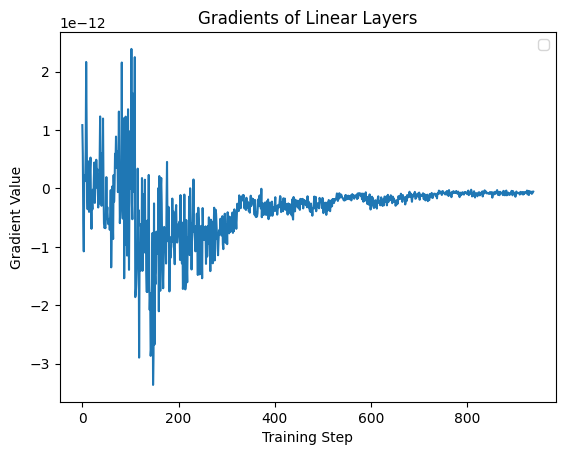

In [ ]:
# Визуализируйте градиент:
plt.plot(torch.tensor(fc_gradients).cpu())
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно.

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [ ]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input

**Пример ответа:** `0.234`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Вызываем forward с полученным тензоров test_input и суммируем значения полученного массива</div>
</div>

In [ ]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [ ]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
output = model(test_input)

answer = torch.sum(output)
answer   ### здесь должен быть выведен ответ

tensor(-0.2574, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  1%|          | 10/938 [00:00<00:19, 47.72it/s]

Step: 0, Loss: 2.3037009239196777
Step: 10, Loss: 2.2954561710357666


  3%|▎         | 30/938 [00:00<00:16, 55.20it/s]

Step: 20, Loss: 2.302825689315796
Step: 30, Loss: 2.304784059524536


  5%|▌         | 49/938 [00:00<00:15, 57.01it/s]

Step: 40, Loss: 2.2691526412963867
Step: 50, Loss: 2.2142844200134277


  7%|▋         | 70/938 [00:01<00:14, 59.24it/s]

Step: 60, Loss: 1.9159643650054932
Step: 70, Loss: 1.9696029424667358


 10%|▉         | 91/938 [00:01<00:13, 61.97it/s]

Step: 80, Loss: 1.8537713289260864
Step: 90, Loss: 1.8757920265197754


 12%|█▏        | 112/938 [00:01<00:13, 60.66it/s]

Step: 100, Loss: 1.755249261856079
Step: 110, Loss: 1.9241080284118652


 14%|█▎        | 128/938 [00:02<00:12, 64.88it/s]

Step: 120, Loss: 1.6213148832321167
Step: 130, Loss: 1.592047929763794


 16%|█▌        | 149/938 [00:02<00:12, 62.46it/s]

Step: 140, Loss: 1.6301336288452148
Step: 150, Loss: 1.4148064851760864


 18%|█▊        | 170/938 [00:02<00:12, 61.86it/s]

Step: 160, Loss: 1.3613747358322144
Step: 170, Loss: 1.7583119869232178


 20%|██        | 192/938 [00:03<00:11, 65.23it/s]

Step: 180, Loss: 1.4944343566894531
Step: 190, Loss: 1.3037604093551636


 23%|██▎       | 213/938 [00:03<00:11, 62.38it/s]

Step: 200, Loss: 1.3115638494491577
Step: 210, Loss: 1.5537954568862915


 24%|██▍       | 227/938 [00:03<00:12, 58.65it/s]

Step: 220, Loss: 1.300612211227417
Step: 230, Loss: 1.347327709197998


 26%|██▋       | 248/938 [00:04<00:10, 63.09it/s]

Step: 240, Loss: 1.8815038204193115
Step: 250, Loss: 1.3414229154586792


 29%|██▊       | 269/938 [00:04<00:11, 58.87it/s]

Step: 260, Loss: 1.6142351627349854


 29%|██▉       | 275/938 [00:04<00:12, 54.19it/s]

Step: 270, Loss: 1.4904329776763916
Step: 280, Loss: 2.08734130859375


 32%|███▏      | 302/938 [00:05<00:10, 58.40it/s]

Step: 290, Loss: 2.2944140434265137
Step: 300, Loss: 1.989254355430603


 34%|███▍      | 323/938 [00:05<00:09, 61.56it/s]

Step: 310, Loss: 1.7364696264266968
Step: 320, Loss: 1.6963292360305786


 37%|███▋      | 344/938 [00:05<00:09, 62.40it/s]

Step: 330, Loss: 1.570088505744934
Step: 340, Loss: 1.4915575981140137


 38%|███▊      | 359/938 [00:06<00:09, 62.54it/s]

Step: 350, Loss: 1.6097455024719238
Step: 360, Loss: 1.5979137420654297


 41%|████      | 380/938 [00:06<00:08, 62.35it/s]

Step: 370, Loss: 1.5623785257339478
Step: 380, Loss: 1.485694408416748


 43%|████▎     | 401/938 [00:06<00:08, 61.38it/s]

Step: 390, Loss: 1.3820677995681763
Step: 400, Loss: 1.5611592531204224


 45%|████▍     | 422/938 [00:07<00:08, 60.18it/s]

Step: 410, Loss: 1.4013158082962036
Step: 420, Loss: 1.451932668685913


 46%|████▋     | 435/938 [00:07<00:10, 48.59it/s]

Step: 430, Loss: 1.3206346035003662


 48%|████▊     | 447/938 [00:07<00:10, 45.51it/s]

Step: 440, Loss: 1.4083579778671265


 49%|████▊     | 457/938 [00:07<00:11, 43.48it/s]

Step: 450, Loss: 1.3467603921890259


 50%|████▉     | 467/938 [00:08<00:11, 40.71it/s]

Step: 460, Loss: 1.388302206993103


 51%|█████     | 477/938 [00:08<00:11, 40.23it/s]

Step: 470, Loss: 1.1975218057632446


 52%|█████▏    | 487/938 [00:08<00:11, 40.30it/s]

Step: 480, Loss: 1.322036862373352


 53%|█████▎    | 498/938 [00:08<00:10, 40.66it/s]

Step: 490, Loss: 1.2698763608932495


 54%|█████▎    | 503/938 [00:09<00:11, 39.06it/s]

Step: 500, Loss: 1.2775744199752808


 55%|█████▍    | 514/938 [00:09<00:10, 41.83it/s]

Step: 510, Loss: 1.5005029439926147


 56%|█████▌    | 524/938 [00:09<00:10, 40.65it/s]

Step: 520, Loss: 1.6284371614456177


 57%|█████▋    | 537/938 [00:09<00:10, 36.50it/s]

Step: 530, Loss: 1.3923218250274658


 58%|█████▊    | 545/938 [00:10<00:10, 36.20it/s]

Step: 540, Loss: 1.2296490669250488


 60%|█████▉    | 560/938 [00:10<00:09, 42.00it/s]

Step: 550, Loss: 1.216318130493164
Step: 560, Loss: 1.3948431015014648


 62%|██████▏   | 582/938 [00:10<00:06, 55.26it/s]

Step: 570, Loss: 1.504318118095398
Step: 580, Loss: 1.2066500186920166


 64%|██████▎   | 596/938 [00:11<00:05, 58.55it/s]

Step: 590, Loss: 1.6481425762176514
Step: 600, Loss: 1.1961365938186646


 66%|██████▌   | 617/938 [00:11<00:05, 60.18it/s]

Step: 610, Loss: 1.1553452014923096
Step: 620, Loss: 1.3278205394744873


 68%|██████▊   | 638/938 [00:11<00:04, 63.49it/s]

Step: 630, Loss: 1.9986506700515747
Step: 640, Loss: 1.1789354085922241


 70%|███████   | 659/938 [00:12<00:04, 60.34it/s]

Step: 650, Loss: 1.118448257446289
Step: 660, Loss: 1.355739951133728


 72%|███████▏  | 680/938 [00:12<00:04, 58.70it/s]

Step: 670, Loss: 1.2797014713287354
Step: 680, Loss: 1.4839719533920288


 75%|███████▍  | 701/938 [00:12<00:03, 61.61it/s]

Step: 690, Loss: 1.3770241737365723
Step: 700, Loss: 1.576735019683838


 77%|███████▋  | 722/938 [00:13<00:03, 62.65it/s]

Step: 710, Loss: 1.2814499139785767
Step: 720, Loss: 4.790157318115234


 78%|███████▊  | 736/938 [00:13<00:03, 60.93it/s]

Step: 730, Loss: 1.3061635494232178
Step: 740, Loss: 1.2562466859817505


 81%|████████  | 758/938 [00:13<00:02, 62.60it/s]

Step: 750, Loss: 1.035500168800354
Step: 760, Loss: 1.2243064641952515


 83%|████████▎ | 780/938 [00:14<00:02, 64.94it/s]

Step: 770, Loss: 1.2910391092300415
Step: 780, Loss: 1.197306513786316


 85%|████████▌ | 801/938 [00:14<00:02, 62.00it/s]

Step: 790, Loss: 1.270922064781189
Step: 800, Loss: 1.152504563331604


 88%|████████▊ | 823/938 [00:14<00:01, 63.53it/s]

Step: 810, Loss: 1.0426437854766846
Step: 820, Loss: 1.4269789457321167


 89%|████████▉ | 837/938 [00:15<00:01, 62.37it/s]

Step: 830, Loss: 1.0927705764770508
Step: 840, Loss: 1.0427659749984741


 92%|█████████▏| 859/938 [00:15<00:01, 61.19it/s]

Step: 850, Loss: 1.4467620849609375
Step: 860, Loss: 0.9785715341567993


 94%|█████████▍| 881/938 [00:15<00:00, 62.35it/s]

Step: 870, Loss: 1.0249103307724
Step: 880, Loss: 0.9940614104270935


 96%|█████████▋| 903/938 [00:16<00:00, 65.04it/s]

Step: 890, Loss: 1.119301438331604
Step: 900, Loss: 1.4805970191955566


 99%|█████████▊| 924/938 [00:16<00:00, 62.18it/s]

Step: 910, Loss: 1.1320809125900269
Step: 920, Loss: 0.9201682806015015


100%|██████████| 938/938 [00:16<00:00, 56.19it/s]

Step: 930, Loss: 1.3256943225860596


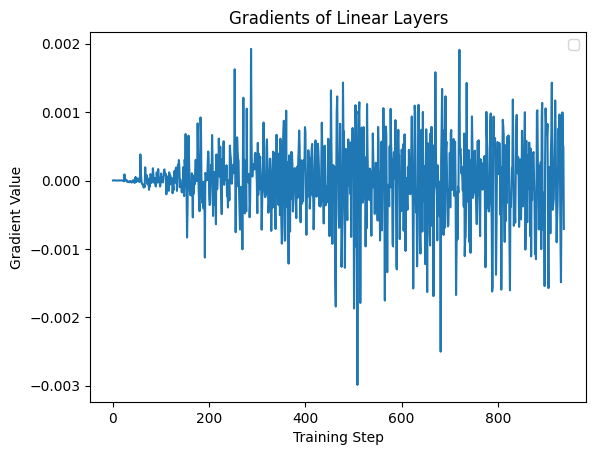

In [ ]:
# Визуализируйте градинте:
plt.plot(torch.tensor(fc_gradients).cpu())
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [ ]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Аналогично, суммируем выход модели после инференса</div>
</div>

In [ ]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
output = model(test_input)

answer = torch.sum(output)
answer   ### здесь должен быть выведен ответ

tensor(-0.9367, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 8/938 [00:00<00:21, 43.99it/s]

Step: 0, Loss: 2.370612144470215
Step: 10, Loss: 2.319352149963379


  4%|▎         | 33/938 [00:00<00:16, 55.81it/s]

Step: 20, Loss: 2.384559392929077
Step: 30, Loss: 2.322371482849121


  5%|▌         | 51/938 [00:00<00:15, 57.22it/s]

Step: 40, Loss: 2.3334951400756836
Step: 50, Loss: 2.335846185684204


  7%|▋         | 69/938 [00:01<00:16, 54.30it/s]

Step: 60, Loss: 2.337700843811035
Step: 70, Loss: 2.294940948486328


  9%|▉         | 88/938 [00:01<00:14, 57.83it/s]

Step: 80, Loss: 2.3135998249053955
Step: 90, Loss: 2.3037660121917725


 12%|█▏        | 112/938 [00:02<00:14, 55.31it/s]

Step: 100, Loss: 2.3035049438476562
Step: 110, Loss: 2.311680316925049


 14%|█▍        | 130/938 [00:02<00:15, 53.40it/s]

Step: 120, Loss: 2.2950565814971924
Step: 130, Loss: 2.2916624546051025


 16%|█▌        | 148/938 [00:02<00:14, 56.27it/s]

Step: 140, Loss: 2.303668260574341
Step: 150, Loss: 2.308089017868042


 18%|█▊        | 172/938 [00:03<00:14, 54.32it/s]

Step: 160, Loss: 2.294508457183838
Step: 170, Loss: 2.299661636352539


 20%|█▉        | 184/938 [00:03<00:14, 52.85it/s]

Step: 180, Loss: 2.30952787399292


 21%|██        | 195/938 [00:03<00:17, 43.14it/s]

Step: 190, Loss: 2.3046488761901855


 22%|██▏       | 205/938 [00:03<00:16, 44.14it/s]

Step: 200, Loss: 2.2925260066986084


 23%|██▎       | 215/938 [00:04<00:17, 42.33it/s]

Step: 210, Loss: 2.297971725463867


 24%|██▍       | 226/938 [00:04<00:17, 41.07it/s]

Step: 220, Loss: 2.3187084197998047


 26%|██▌       | 241/938 [00:04<00:16, 42.86it/s]

Step: 230, Loss: 2.296956777572632
Step: 240, Loss: 2.320816993713379


 27%|██▋       | 255/938 [00:05<00:19, 35.71it/s]

Step: 250, Loss: 2.3015003204345703


 29%|██▊       | 268/938 [00:05<00:17, 38.48it/s]

Step: 260, Loss: 2.3070170879364014


 29%|██▉       | 276/938 [00:05<00:17, 37.33it/s]

Step: 270, Loss: 2.304478406906128


 30%|███       | 285/938 [00:06<00:19, 33.13it/s]

Step: 280, Loss: 2.3052568435668945


 31%|███▏      | 295/938 [00:06<00:17, 36.09it/s]

Step: 290, Loss: 2.3059661388397217


 32%|███▏      | 303/938 [00:06<00:20, 31.37it/s]

Step: 300, Loss: 2.3120131492614746


 34%|███▎      | 316/938 [00:07<00:19, 31.29it/s]

Step: 310, Loss: 2.291264057159424


 35%|███▍      | 328/938 [00:07<00:18, 33.43it/s]

Step: 320, Loss: 2.298677682876587


 36%|███▌      | 338/938 [00:07<00:15, 38.29it/s]

Step: 330, Loss: 2.296095609664917


 37%|███▋      | 346/938 [00:07<00:16, 36.79it/s]

Step: 340, Loss: 2.305849313735962


 38%|███▊      | 355/938 [00:08<00:15, 36.87it/s]

Step: 350, Loss: 2.3076021671295166


 39%|███▉      | 369/938 [00:08<00:13, 41.00it/s]

Step: 360, Loss: 2.2834110260009766


 40%|████      | 378/938 [00:08<00:14, 38.27it/s]

Step: 370, Loss: 2.298788547515869


 41%|████      | 386/938 [00:08<00:15, 35.96it/s]

Step: 380, Loss: 2.303243398666382


 42%|████▏     | 396/938 [00:09<00:13, 41.67it/s]

Step: 390, Loss: 2.30169415473938


 43%|████▎     | 406/938 [00:09<00:14, 37.34it/s]

Step: 400, Loss: 2.3153207302093506


 44%|████▍     | 414/938 [00:09<00:15, 34.78it/s]

Step: 410, Loss: 2.3035590648651123


 46%|████▌     | 428/938 [00:10<00:13, 38.87it/s]

Step: 420, Loss: 2.306709051132202


 46%|████▋     | 436/938 [00:10<00:14, 34.76it/s]

Step: 430, Loss: 2.301382064819336


 48%|████▊     | 451/938 [00:10<00:12, 38.83it/s]

Step: 440, Loss: 2.3099207878112793
Step: 450, Loss: 2.3080391883850098


 50%|████▉     | 467/938 [00:10<00:09, 47.16it/s]

Step: 460, Loss: 2.2981133460998535
Step: 470, Loss: 2.296691417694092


 52%|█████▏    | 491/938 [00:11<00:08, 53.51it/s]

Step: 480, Loss: 2.2905995845794678
Step: 490, Loss: 2.301241874694824


 54%|█████▍    | 509/938 [00:11<00:08, 53.25it/s]

Step: 500, Loss: 2.303941249847412


 56%|█████▌    | 521/938 [00:11<00:08, 51.85it/s]

Step: 510, Loss: 2.3054370880126953
Step: 520, Loss: 2.295976161956787


 57%|█████▋    | 539/938 [00:12<00:07, 52.68it/s]

Step: 530, Loss: 2.29780912399292
Step: 540, Loss: 2.3027031421661377


 59%|█████▉    | 557/938 [00:12<00:07, 53.16it/s]

Step: 550, Loss: 2.3001866340637207


 61%|██████    | 570/938 [00:12<00:07, 51.68it/s]

Step: 560, Loss: 2.296241283416748
Step: 570, Loss: 2.3105454444885254


 63%|██████▎   | 588/938 [00:13<00:06, 53.44it/s]

Step: 580, Loss: 2.3034372329711914
Step: 590, Loss: 2.313382625579834


 65%|██████▍   | 606/938 [00:13<00:06, 53.92it/s]

Step: 600, Loss: 2.293776750564575
Step: 610, Loss: 2.31894588470459


 67%|██████▋   | 631/938 [00:14<00:05, 55.38it/s]

Step: 620, Loss: 2.3001785278320312
Step: 630, Loss: 2.309185266494751


 69%|██████▉   | 649/938 [00:14<00:05, 54.55it/s]

Step: 640, Loss: 2.2854819297790527
Step: 650, Loss: 2.299595355987549


 71%|███████   | 667/938 [00:14<00:05, 53.87it/s]

Step: 660, Loss: 2.3087782859802246
Step: 670, Loss: 2.292625665664673


 74%|███████▎  | 691/938 [00:15<00:04, 54.36it/s]

Step: 680, Loss: 2.312490224838257
Step: 690, Loss: 2.3027215003967285


 76%|███████▌  | 709/938 [00:15<00:04, 56.71it/s]

Step: 700, Loss: 2.3031020164489746
Step: 710, Loss: 2.2977705001831055


 78%|███████▊  | 728/938 [00:15<00:03, 57.20it/s]

Step: 720, Loss: 2.310284376144409
Step: 730, Loss: 2.3078012466430664


 80%|███████▉  | 746/938 [00:16<00:03, 54.73it/s]

Step: 740, Loss: 2.2944319248199463
Step: 750, Loss: 2.296509027481079


 82%|████████▏ | 770/938 [00:16<00:03, 54.58it/s]

Step: 760, Loss: 2.3016974925994873
Step: 770, Loss: 2.315286636352539


 84%|████████▍ | 788/938 [00:16<00:02, 55.52it/s]

Step: 780, Loss: 2.292431116104126
Step: 790, Loss: 2.2961673736572266


 86%|████████▌ | 806/938 [00:17<00:02, 49.44it/s]

Step: 800, Loss: 2.297883987426758


 87%|████████▋ | 817/938 [00:17<00:02, 42.96it/s]

Step: 810, Loss: 2.3135786056518555


 88%|████████▊ | 827/938 [00:17<00:02, 39.11it/s]

Step: 820, Loss: 2.307420253753662


 89%|████████▉ | 837/938 [00:18<00:02, 42.28it/s]

Step: 830, Loss: 2.3165266513824463


 90%|█████████ | 847/938 [00:18<00:02, 41.12it/s]

Step: 840, Loss: 2.305375337600708


 91%|█████████▏| 857/938 [00:18<00:02, 39.09it/s]

Step: 850, Loss: 2.3068716526031494


 92%|█████████▏| 866/938 [00:18<00:01, 41.58it/s]

Step: 860, Loss: 2.3002524375915527


 93%|█████████▎| 876/938 [00:19<00:01, 40.42it/s]

Step: 870, Loss: 2.2848072052001953


 94%|█████████▍| 886/938 [00:19<00:01, 35.88it/s]

Step: 880, Loss: 2.3027474880218506


 96%|█████████▌| 897/938 [00:19<00:01, 38.40it/s]

Step: 890, Loss: 2.299281358718872


 96%|█████████▋| 905/938 [00:19<00:00, 35.52it/s]

Step: 900, Loss: 2.303833246231079


 98%|█████████▊| 918/938 [00:20<00:00, 35.44it/s]

Step: 910, Loss: 2.2965760231018066


 99%|█████████▊| 926/938 [00:20<00:00, 35.31it/s]

Step: 920, Loss: 2.2989602088928223


100%|█████████▉| 934/938 [00:20<00:00, 33.17it/s]

Step: 930, Loss: 2.294469118118286


100%|██████████| 938/938 [00:20<00:00, 44.98it/s]


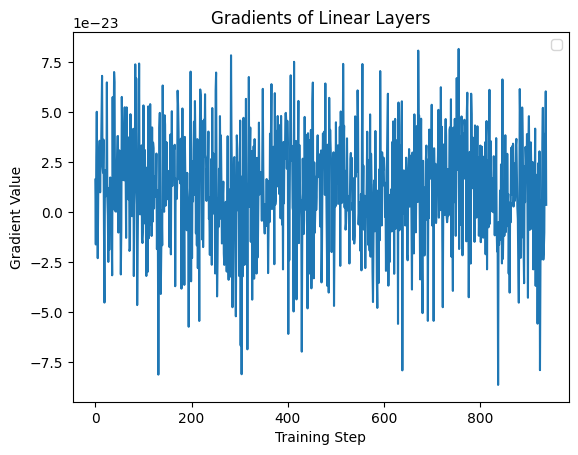

In [ ]:
# Визуализируйте градиент:
plt.plot(torch.tensor(fc_gradients).cpu())
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [ ]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10,10)
answer = res_block(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(16789.0645, grad_fn=<SumBackward0>)

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Аналогично, суммируем все обучаемые параметры</div>
</div>

In [ ]:
model = ResNet()
model_parameters = filter(lambda param: param.requires_grad, model.parameters())
answer = sum([np.prod(param.size()) for param in model_parameters])
answer   ### здесь должен быть выведен ответ

2799114

In [ ]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  0%|          | 2/938 [00:01<07:26,  2.10it/s]

Step: 0, Loss: 2.4625658988952637


  1%|▏         | 12/938 [00:02<02:01,  7.63it/s]

Step: 10, Loss: 4.516711235046387


  2%|▏         | 22/938 [00:03<01:54,  7.98it/s]

Step: 20, Loss: 1.7550970315933228


  3%|▎         | 32/938 [00:04<01:53,  8.02it/s]

Step: 30, Loss: 1.2031744718551636


  4%|▍         | 42/938 [00:06<01:51,  8.01it/s]

Step: 40, Loss: 1.0667994022369385


  6%|▌         | 52/938 [00:07<01:51,  7.94it/s]

Step: 50, Loss: 0.9085254073143005


  7%|▋         | 62/938 [00:08<01:50,  7.95it/s]

Step: 60, Loss: 0.28151735663414


  8%|▊         | 72/938 [00:09<01:52,  7.72it/s]

Step: 70, Loss: 0.35718706250190735


  9%|▊         | 82/938 [00:11<01:52,  7.58it/s]

Step: 80, Loss: 0.4216713607311249


 10%|▉         | 92/938 [00:12<01:50,  7.65it/s]

Step: 90, Loss: 0.4520687162876129


 11%|█         | 102/938 [00:13<01:45,  7.89it/s]

Step: 100, Loss: 0.5272232890129089


 12%|█▏        | 112/938 [00:15<01:44,  7.92it/s]

Step: 110, Loss: 0.43409979343414307


 13%|█▎        | 122/938 [00:16<01:43,  7.90it/s]

Step: 120, Loss: 0.3290789723396301


 14%|█▍        | 132/938 [00:17<01:41,  7.94it/s]

Step: 130, Loss: 0.17730343341827393


 15%|█▌        | 142/938 [00:18<01:40,  7.90it/s]

Step: 140, Loss: 0.1687646210193634


 16%|█▌        | 152/938 [00:20<01:39,  7.87it/s]

Step: 150, Loss: 0.06899511814117432


 17%|█▋        | 162/938 [00:21<01:38,  7.89it/s]

Step: 160, Loss: 0.34584155678749084


 18%|█▊        | 172/938 [00:22<01:41,  7.57it/s]

Step: 170, Loss: 0.3393796980381012


 19%|█▉        | 182/938 [00:24<01:52,  6.75it/s]

Step: 180, Loss: 0.2927292585372925


 20%|██        | 192/938 [00:25<01:37,  7.66it/s]

Step: 190, Loss: 0.15524497628211975


 22%|██▏       | 202/938 [00:26<01:35,  7.70it/s]

Step: 200, Loss: 0.17242176830768585


 23%|██▎       | 212/938 [00:28<01:33,  7.80it/s]

Step: 210, Loss: 0.37611469626426697


 24%|██▎       | 222/938 [00:29<01:31,  7.79it/s]

Step: 220, Loss: 0.11095699667930603


 25%|██▍       | 232/938 [00:30<01:30,  7.76it/s]

Step: 230, Loss: 0.1306932419538498


 26%|██▌       | 242/938 [00:31<01:29,  7.75it/s]

Step: 240, Loss: 0.03305581957101822


 27%|██▋       | 252/938 [00:33<01:28,  7.75it/s]

Step: 250, Loss: 0.05867672339081764


 28%|██▊       | 262/938 [00:34<01:28,  7.63it/s]

Step: 260, Loss: 0.08356883376836777


 29%|██▉       | 272/938 [00:35<01:30,  7.39it/s]

Step: 270, Loss: 0.036155860871076584


 30%|███       | 282/938 [00:37<01:27,  7.48it/s]

Step: 280, Loss: 0.14587363600730896


 31%|███       | 292/938 [00:38<01:24,  7.68it/s]

Step: 290, Loss: 0.07667273283004761


 32%|███▏      | 302/938 [00:39<01:22,  7.73it/s]

Step: 300, Loss: 0.22496086359024048


 33%|███▎      | 312/938 [00:41<01:21,  7.66it/s]

Step: 310, Loss: 0.08069387823343277


 34%|███▍      | 322/938 [00:42<01:20,  7.66it/s]

Step: 320, Loss: 0.22203221917152405


 35%|███▌      | 332/938 [00:43<01:19,  7.63it/s]

Step: 330, Loss: 0.06016809120774269


 36%|███▋      | 342/938 [00:45<01:18,  7.64it/s]

Step: 340, Loss: 0.14793463051319122


 38%|███▊      | 352/938 [00:46<01:16,  7.63it/s]

Step: 350, Loss: 0.04716429486870766


 39%|███▊      | 362/938 [00:47<01:15,  7.63it/s]

Step: 360, Loss: 0.08424019068479538


 40%|███▉      | 372/938 [00:48<01:15,  7.47it/s]

Step: 370, Loss: 0.016153385862708092


 41%|████      | 382/938 [00:50<01:15,  7.37it/s]

Step: 380, Loss: 0.08361797779798508


 42%|████▏     | 392/938 [00:51<01:12,  7.53it/s]

Step: 390, Loss: 0.1421830654144287


 43%|████▎     | 402/938 [00:52<01:10,  7.59it/s]

Step: 400, Loss: 0.1834079623222351


 44%|████▍     | 412/938 [00:54<01:09,  7.57it/s]

Step: 410, Loss: 0.025107767432928085


 45%|████▍     | 422/938 [00:55<01:08,  7.51it/s]

Step: 420, Loss: 0.17156696319580078


 46%|████▌     | 432/938 [00:56<01:07,  7.49it/s]

Step: 430, Loss: 0.062798872590065


 47%|████▋     | 442/938 [00:58<01:05,  7.55it/s]

Step: 440, Loss: 0.20085886120796204


 48%|████▊     | 452/938 [00:59<01:05,  7.47it/s]

Step: 450, Loss: 0.10123054683208466


 49%|████▉     | 462/938 [01:00<01:03,  7.52it/s]

Step: 460, Loss: 0.08578871190547943


 50%|█████     | 472/938 [01:02<01:04,  7.24it/s]

Step: 470, Loss: 0.06245925650000572


 51%|█████▏    | 482/938 [01:03<01:03,  7.21it/s]

Step: 480, Loss: 0.09264639765024185


 52%|█████▏    | 492/938 [01:05<00:59,  7.45it/s]

Step: 490, Loss: 0.058018751442432404


 54%|█████▎    | 502/938 [01:06<00:59,  7.38it/s]

Step: 500, Loss: 0.14702396094799042


 55%|█████▍    | 512/938 [01:07<00:57,  7.39it/s]

Step: 510, Loss: 0.10341134667396545


 56%|█████▌    | 522/938 [01:09<00:56,  7.36it/s]

Step: 520, Loss: 0.12341499328613281


 57%|█████▋    | 532/938 [01:10<00:55,  7.36it/s]

Step: 530, Loss: 0.11987999081611633


 58%|█████▊    | 542/938 [01:11<00:53,  7.34it/s]

Step: 540, Loss: 0.08510816097259521


 59%|█████▉    | 552/938 [01:13<00:52,  7.32it/s]

Step: 550, Loss: 0.05750265717506409


 60%|█████▉    | 562/938 [01:14<00:52,  7.15it/s]

Step: 560, Loss: 0.033298738300800323


 61%|██████    | 572/938 [01:16<00:51,  7.10it/s]

Step: 570, Loss: 0.06734742969274521


 62%|██████▏   | 582/938 [01:17<00:50,  7.08it/s]

Step: 580, Loss: 0.2950090765953064


 63%|██████▎   | 592/938 [01:18<00:47,  7.23it/s]

Step: 590, Loss: 0.36184653639793396


 64%|██████▍   | 602/938 [01:20<00:47,  7.13it/s]

Step: 600, Loss: 0.15771423280239105


 65%|██████▌   | 612/938 [01:21<00:46,  7.08it/s]

Step: 610, Loss: 0.05671868845820427


 66%|██████▋   | 622/938 [01:23<00:44,  7.16it/s]

Step: 620, Loss: 0.09911119192838669


 67%|██████▋   | 632/938 [01:24<00:43,  7.02it/s]

Step: 630, Loss: 0.3263531029224396


 68%|██████▊   | 642/938 [01:25<00:41,  7.05it/s]

Step: 640, Loss: 0.020930150523781776


 70%|██████▉   | 652/938 [01:27<00:41,  6.95it/s]

Step: 650, Loss: 0.06359041482210159


 71%|███████   | 662/938 [01:28<00:40,  6.82it/s]

Step: 660, Loss: 0.046426936984062195


 72%|███████▏  | 672/938 [01:30<00:38,  6.88it/s]

Step: 670, Loss: 0.07466384768486023


 73%|███████▎  | 682/938 [01:31<00:36,  7.05it/s]

Step: 680, Loss: 0.21253667771816254


 74%|███████▍  | 692/938 [01:33<00:34,  7.11it/s]

Step: 690, Loss: 0.17559711635112762


 75%|███████▍  | 702/938 [01:34<00:34,  6.90it/s]

Step: 700, Loss: 0.028325969353318214


 76%|███████▌  | 712/938 [01:35<00:32,  7.03it/s]

Step: 710, Loss: 0.13092322647571564


 77%|███████▋  | 722/938 [01:37<00:30,  6.99it/s]

Step: 720, Loss: 0.06200001388788223


 78%|███████▊  | 732/938 [01:38<00:29,  6.97it/s]

Step: 730, Loss: 0.0603613518178463


 79%|███████▉  | 742/938 [01:40<00:28,  6.89it/s]

Step: 740, Loss: 0.06210207939147949


 80%|████████  | 752/938 [01:41<00:26,  6.92it/s]

Step: 750, Loss: 0.03435932472348213


 81%|████████  | 762/938 [01:43<00:25,  7.00it/s]

Step: 760, Loss: 0.061072636395692825


 82%|████████▏ | 772/938 [01:44<00:23,  7.06it/s]

Step: 770, Loss: 0.10345350205898285


 83%|████████▎ | 782/938 [01:45<00:22,  7.06it/s]

Step: 780, Loss: 0.11078763008117676


 84%|████████▍ | 792/938 [01:47<00:20,  7.07it/s]

Step: 790, Loss: 0.07976459711790085


 86%|████████▌ | 802/938 [01:48<00:19,  7.08it/s]

Step: 800, Loss: 0.1104041114449501


 87%|████████▋ | 812/938 [01:50<00:17,  7.03it/s]

Step: 810, Loss: 0.040551237761974335


 88%|████████▊ | 822/938 [01:51<00:16,  7.08it/s]

Step: 820, Loss: 0.11429645866155624


 89%|████████▊ | 832/938 [01:53<00:15,  7.01it/s]

Step: 830, Loss: 0.06379766762256622


 90%|████████▉ | 842/938 [01:54<00:13,  6.89it/s]

Step: 840, Loss: 0.19910158216953278


 91%|█████████ | 852/938 [01:55<00:12,  7.11it/s]

Step: 850, Loss: 0.14422821998596191


 92%|█████████▏| 862/938 [01:57<00:10,  7.18it/s]

Step: 860, Loss: 0.041053518652915955


 93%|█████████▎| 872/938 [01:58<00:09,  7.21it/s]

Step: 870, Loss: 0.17632071673870087


 94%|█████████▍| 882/938 [02:00<00:07,  7.22it/s]

Step: 880, Loss: 0.027130117639899254


 95%|█████████▌| 892/938 [02:01<00:06,  7.20it/s]

Step: 890, Loss: 0.0154296038672328


 96%|█████████▌| 902/938 [02:02<00:05,  7.09it/s]

Step: 900, Loss: 0.11605950444936752


 97%|█████████▋| 912/938 [02:04<00:03,  7.21it/s]

Step: 910, Loss: 0.084653340280056


 98%|█████████▊| 922/938 [02:05<00:02,  7.22it/s]

Step: 920, Loss: 0.036563366651535034


 99%|█████████▉| 932/938 [02:07<00:00,  6.97it/s]

Step: 930, Loss: 0.13192115724086761


100%|██████████| 938/938 [02:07<00:00,  7.33it/s]


Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

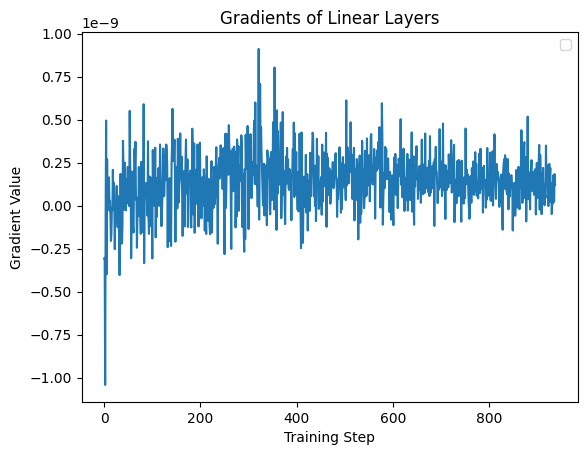

In [ ]:
# Визуализируйте градиент:
plt.plot(torch.tensor(fc_gradients).cpu())
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [ ]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [ ]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [ ]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [ ]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Используем объявленную выше функцию test</div>
</div>

In [ ]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.17it/s]


MNIST test accuracy: 97.7%


Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [ ]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 41861092.24it/s]


Extracting ./data_cifar10/cifar-10-python.tar.gz to ./data_cifar10
Files already downloaded and verified


Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [ ]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.55it/s]


Test accuracy: 9.99%


Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [ ]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)

mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Считаем параметры с отключенным флагом requires_grad</div>
</div>

In [ ]:
model_parameters = filter(lambda param: param.requires_grad == False, model.parameters())
frozen_params = sum([np.prod(param.size()) for param in model_parameters])
frozen_params   ### здесь должен быть выведен ответ

2776064

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [ ]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

  1%|          | 4/782 [00:00<00:51, 15.14it/s]

Step: 0, Loss: 2.31402325630188


  2%|▏         | 14/782 [00:00<00:36, 20.82it/s]

Step: 10, Loss: 2.3379759788513184


  3%|▎         | 25/782 [00:01<00:38, 19.76it/s]

Step: 20, Loss: 2.130249261856079


  4%|▍         | 34/782 [00:01<00:37, 19.98it/s]

Step: 30, Loss: 2.2163867950439453


  6%|▌         | 46/782 [00:02<00:35, 20.85it/s]

Step: 40, Loss: 2.1519646644592285


  7%|▋         | 55/782 [00:02<00:35, 20.46it/s]

Step: 50, Loss: 1.9759842157363892


  8%|▊         | 64/782 [00:03<00:34, 20.69it/s]

Step: 60, Loss: 2.3073291778564453


 10%|▉         | 76/782 [00:03<00:34, 20.58it/s]

Step: 70, Loss: 1.8200937509536743


 11%|█         | 85/782 [00:04<00:34, 20.29it/s]

Step: 80, Loss: 1.977938175201416


 12%|█▏        | 94/782 [00:04<00:32, 20.85it/s]

Step: 90, Loss: 2.167757272720337


 13%|█▎        | 103/782 [00:05<00:33, 20.04it/s]

Step: 100, Loss: 1.8982652425765991


 15%|█▍        | 115/782 [00:05<00:32, 20.27it/s]

Step: 110, Loss: 2.023104190826416


 16%|█▌        | 124/782 [00:06<00:32, 20.53it/s]

Step: 120, Loss: 1.657188057899475


 17%|█▋        | 133/782 [00:06<00:31, 20.30it/s]

Step: 130, Loss: 2.3249757289886475


 19%|█▊        | 145/782 [00:07<00:31, 20.18it/s]

Step: 140, Loss: 2.48107647895813


 20%|█▉        | 154/782 [00:07<00:30, 20.47it/s]

Step: 150, Loss: 2.2022271156311035


 21%|██        | 163/782 [00:08<00:31, 19.84it/s]

Step: 160, Loss: 2.343140125274658


 22%|██▏       | 175/782 [00:08<00:30, 19.98it/s]

Step: 170, Loss: 2.1993558406829834


 24%|██▎       | 184/782 [00:09<00:29, 20.31it/s]

Step: 180, Loss: 1.9870100021362305


 25%|██▍       | 193/782 [00:09<00:29, 19.80it/s]

Step: 190, Loss: 2.0839295387268066


 26%|██▌       | 205/782 [00:10<00:29, 19.87it/s]

Step: 200, Loss: 2.1384503841400146


 27%|██▋       | 215/782 [00:10<00:28, 19.95it/s]

Step: 210, Loss: 1.8748146295547485


 29%|██▊       | 224/782 [00:11<00:27, 20.40it/s]

Step: 220, Loss: 2.0518476963043213


 30%|██▉       | 233/782 [00:11<00:27, 19.91it/s]

Step: 230, Loss: 1.7119110822677612


 31%|███       | 244/782 [00:12<00:26, 20.36it/s]

Step: 240, Loss: 1.7675344944000244


 32%|███▏      | 253/782 [00:12<00:27, 19.44it/s]

Step: 250, Loss: 1.900821566581726


 34%|███▍      | 265/782 [00:13<00:26, 19.68it/s]

Step: 260, Loss: 2.114980459213257


 35%|███▌      | 275/782 [00:13<00:26, 19.41it/s]

Step: 270, Loss: 2.2413196563720703


 36%|███▋      | 285/782 [00:14<00:25, 19.61it/s]

Step: 280, Loss: 2.107764720916748


 38%|███▊      | 294/782 [00:14<00:25, 19.24it/s]

Step: 290, Loss: 1.9714281558990479


 39%|███▉      | 304/782 [00:15<00:24, 19.62it/s]

Step: 300, Loss: 2.0743727684020996


 40%|████      | 313/782 [00:15<00:23, 19.69it/s]

Step: 310, Loss: 1.8459312915802002


 42%|████▏     | 325/782 [00:16<00:23, 19.67it/s]

Step: 320, Loss: 2.1901464462280273


 43%|████▎     | 334/782 [00:16<00:22, 19.89it/s]

Step: 330, Loss: 1.9389023780822754


 44%|████▍     | 343/782 [00:17<00:22, 19.45it/s]

Step: 340, Loss: 1.651084542274475


 45%|████▌     | 355/782 [00:18<00:21, 19.56it/s]

Step: 350, Loss: 2.051701307296753


 47%|████▋     | 364/782 [00:18<00:20, 20.14it/s]

Step: 360, Loss: 1.8325318098068237


 48%|████▊     | 373/782 [00:18<00:21, 19.46it/s]

Step: 370, Loss: 1.8780466318130493


 49%|████▉     | 385/782 [00:19<00:20, 19.49it/s]

Step: 380, Loss: 1.7859570980072021


 50%|█████     | 394/782 [00:20<00:19, 19.97it/s]

Step: 390, Loss: 1.8556381464004517


 52%|█████▏    | 405/782 [00:20<00:19, 19.44it/s]

Step: 400, Loss: 1.911534309387207


 53%|█████▎    | 414/782 [00:21<00:18, 19.90it/s]

Step: 410, Loss: 2.11399507522583


 54%|█████▍    | 425/782 [00:21<00:18, 19.54it/s]

Step: 420, Loss: 1.9103503227233887


 55%|█████▌    | 434/782 [00:22<00:17, 19.89it/s]

Step: 430, Loss: 1.9347869157791138


 57%|█████▋    | 445/782 [00:22<00:17, 19.44it/s]

Step: 440, Loss: 1.845586895942688


 58%|█████▊    | 454/782 [00:23<00:16, 19.68it/s]

Step: 450, Loss: 2.100273847579956


 59%|█████▉    | 464/782 [00:23<00:15, 19.88it/s]

Step: 460, Loss: 2.002143621444702


 61%|██████    | 475/782 [00:24<00:15, 19.28it/s]

Step: 470, Loss: 1.8177894353866577


 62%|██████▏   | 484/782 [00:24<00:15, 19.82it/s]

Step: 480, Loss: 1.9122211933135986


 63%|██████▎   | 494/782 [00:25<00:14, 19.77it/s]

Step: 490, Loss: 1.8695039749145508


 64%|██████▍   | 504/782 [00:25<00:14, 19.05it/s]

Step: 500, Loss: 2.139779567718506


 66%|██████▌   | 514/782 [00:26<00:14, 18.86it/s]

Step: 510, Loss: 2.219336748123169


 67%|██████▋   | 525/782 [00:26<00:13, 19.05it/s]

Step: 520, Loss: 2.3179476261138916


 68%|██████▊   | 535/782 [00:27<00:12, 19.02it/s]

Step: 530, Loss: 2.191019296646118


 70%|██████▉   | 544/782 [00:27<00:12, 19.09it/s]

Step: 540, Loss: 2.3810744285583496


 71%|███████   | 553/782 [00:28<00:11, 19.13it/s]

Step: 550, Loss: 2.545644760131836


 72%|███████▏  | 564/782 [00:28<00:11, 19.81it/s]

Step: 560, Loss: 2.2267541885375977


 73%|███████▎  | 574/782 [00:29<00:10, 20.15it/s]

Step: 570, Loss: 2.1409687995910645


 75%|███████▍  | 585/782 [00:30<00:10, 19.55it/s]

Step: 580, Loss: 1.9986703395843506


 76%|███████▌  | 594/782 [00:30<00:09, 19.84it/s]

Step: 590, Loss: 1.7990440130233765


 77%|███████▋  | 605/782 [00:31<00:09, 19.43it/s]

Step: 600, Loss: 1.7455486059188843


 79%|███████▊  | 614/782 [00:31<00:08, 19.89it/s]

Step: 610, Loss: 1.7747175693511963


 80%|███████▉  | 625/782 [00:32<00:08, 19.54it/s]

Step: 620, Loss: 2.1050984859466553


 81%|████████  | 634/782 [00:32<00:07, 19.93it/s]

Step: 630, Loss: 2.0603160858154297


 82%|████████▏ | 645/782 [00:33<00:06, 19.63it/s]

Step: 640, Loss: 2.149412155151367


 84%|████████▎ | 654/782 [00:33<00:06, 20.00it/s]

Step: 650, Loss: 1.9560511112213135


 85%|████████▌ | 665/782 [00:34<00:06, 19.47it/s]

Step: 660, Loss: 1.5095255374908447


 86%|████████▌ | 674/782 [00:34<00:05, 20.12it/s]

Step: 670, Loss: 2.1261796951293945


 88%|████████▊ | 685/782 [00:35<00:04, 19.52it/s]

Step: 680, Loss: 2.0193793773651123


 89%|████████▊ | 694/782 [00:35<00:04, 20.18it/s]

Step: 690, Loss: 2.278795003890991


 90%|█████████ | 705/782 [00:36<00:03, 19.53it/s]

Step: 700, Loss: 1.8896692991256714


 91%|█████████▏| 714/782 [00:36<00:03, 20.08it/s]

Step: 710, Loss: 2.0394392013549805


 93%|█████████▎| 725/782 [00:37<00:02, 19.56it/s]

Step: 720, Loss: 1.9263139963150024


 94%|█████████▍| 734/782 [00:37<00:02, 20.14it/s]

Step: 730, Loss: 1.9640564918518066


 95%|█████████▌| 743/782 [00:38<00:01, 19.89it/s]

Step: 740, Loss: 1.4485971927642822


 97%|█████████▋| 755/782 [00:38<00:01, 19.74it/s]

Step: 750, Loss: 1.8275727033615112


 98%|█████████▊| 764/782 [00:39<00:00, 20.06it/s]

Step: 760, Loss: 2.3201487064361572


 99%|█████████▉| 774/782 [00:39<00:00, 19.35it/s]

Step: 770, Loss: 1.5615630149841309


100%|██████████| 782/782 [00:40<00:00, 19.42it/s]

Step: 780, Loss: 2.0189709663391113


**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [ ]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 19.83it/s]


Test accuracy: 37.81%


Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [ ]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 20.22it/s]


MNIST test accuracy: 8.72%


Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:**
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [ ]:
model.fc = mnist_fc                       # верните в модель слой классификации обученный на MNIST
model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 20.74it/s]


CIFAR test accuracy: 9.75%



100%|██████████| 157/157 [00:07<00:00, 20.29it/s]


MNIST test accuracy: 65.69%


# Компиляция моделей PyTorch 2.x

Замерьте скорость работы модели без компиляции:

In [ ]:
import time

start = time.time()
for i in range(10):
    test(model, testloader)
print('W/O compile:', time.time() - start)

100%|██████████| 157/157 [00:07<00:00, 20.27it/s]

W/O compile: 76.98227095603943


**Пример ответа:**
`W/O compile: 3.372831344604492`

Теперь скомпилируйте модель используя функцию `torch.compile(model, mode)` с разными параметрами `mode`:

1) с параметрами по умолчанию `mode=None`

2) `mode="reduce-overhead"`

3) `mode="max-autotune"`.

Замерьте скорость скомпилированных моделей и сравните со скоростью без компиляции:

<div style="width: 100%; background: #eeeeff; padding: 10px">
    <h3>Как решаем</h3>
    <div>Прогреваем компилятор перед каждой компиляцией, чтобы первый прогон замерять уже оптимально</div>
    <div>Выводим сохраненные метрики</div>
</div>

In [ ]:
# Warm-up для компиляции:
torch._dynamo.reset()
default_model = torch.compile(model, mode=None)
test(default_model, testloader)

default_model = torch.compile(model, mode=None)

start = time.time()
for i in range(10):
    test(default_model, testloader)
by_default = time.time() - start

100%|██████████| 157/157 [00:36<00:00,  4.35it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:06<00:00, 25.35it/s]


In [ ]:
# Warm-up для компиляции:
torch._dynamo.reset()
reduce_overhead_model = torch.compile(model, mode="reduce-overhead")
test(reduce_overhead_model, testloader)

reduce_overhead_model = torch.compile(model, mode="reduce-overhead")

start = time.time()
for i in range(10):
    test(reduce_overhead_model, testloader)
reduce_overhead = time.time() - start

100%|██████████| 157/157 [00:14<00:00, 10.65it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:07<00:00, 22.23it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▊| 155/157 [00:06<00:00, 24.75it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:06<00:00, 23.61it/s]


In [ ]:
# Warm-up для компиляции:
torch._dynamo.reset()
max_autotune_model = torch.compile(model, mode="max-autotune")
test(max_autotune_model, testloader)


max_autotune_model = torch.compile(model, mode="max-autotune")

start = time.time()
for i in range(10):
    test(max_autotune_model, testloader)
max_autotune = time.time() - start

  0%|          | 0/157 [00:00<?, ?it/s][2024-05-09 10:47:44,060] [2/0] torch._inductor.utils: [WARNING] not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(50176x128, 50176x64, 64x128)
  addmm 0.5344 ms 100.0%
  bias_addmm 0.5673 ms 94.2%
SingleProcess AUTOTUNE takes 0.2452 seconds
AUTOTUNE addmm(50176x256, 50176x128, 128x256)
  bias_addmm 0.8375 ms 100.0%
  addmm 1.1203 ms 74.8%
SingleProcess AUTOTUNE takes 0.2610 seconds
AUTOTUNE addmm(64x10, 64x2304, 2304x10)
  bias_addmm 0.0151 ms 100.0%
  addmm 0.0205 ms 73.6%
SingleProcess AUTOTUNE takes 0.2213 seconds
 99%|█████████▉| 156/157 [00:15<00:00, 18.42it/s]AUTOTUNE addmm(12544x128, 12544x64, 64x128)
  addmm 0.1536 ms 100.0%
  bias_addmm 0.1702 ms 90.3%
SingleProcess AUTOTUNE takes 0.2252 seconds
AUTOTUNE addmm(12544x256, 12544x128, 128x256)
  bias_addmm 0.1720 ms 100.0%
  addmm 0.2724 ms 63.2%
SingleProcess AUTOTUNE takes 0.2265 seconds
AUTOTUNE addmm(16x10, 16x2304, 2304x10)
  bias_addmm 0.0131 ms 100.0%
  addmm 0.0294 ms 44.6

#### **Пример ответа:**

`by default: 3.11631344604432`

`reduce-overhead: 3.2283134461134`

`max-autotune: 3.5928357860168`

In [ ]:
print(f'by default: {by_default}')
print(f'reduce-overhead: {reduce_overhead}')
print(f'max-autotune: {max_autotune}')

by default: 65.98570132255554
reduce-overhead: 66.77985620498657
max-autotune: 67.2152647972107
